In [ ]:

Patient = "P005" #"P015/P015_S01_D2024-07-06"
run = None

In [2]:
import importlib
import analyzer
importlib.reload(analyzer)
from analyzer import Analyzer
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import json
import numpy as np



def load_patient_data(patient: str, run: str = None):
    """
    Load patient data from the specified file.
    """

    overview = pd.read_excel("Data/overview.xlsx")
    dir = "Data/" + patient + "/"
    number = re.findall(r'\d+', dir)
    patient_number = int(number[0]) if number else None


    if overview.loc[overview["Probanten Nr."] == patient_number, "runs"].values[0].strip() == "-":
        print(f"No runs found for patient {patient_number}. Skipping...")
        return
    
    add_filename, file_name = None, None
    
    for file in os.listdir(dir):
        if file.endswith(".tdms") and file.startswith(patient):
            if run and run not in file:
                continue
            if "addCh" in file:
                add_filename = os.path.join(dir, file)
            else:
                file_name = os.path.join(dir, file)
            
    
    log_file_path = os.path.join(dir, "QZFM_log_file.txt")
    sensor_channels_to_exclude = json.loads(overview.loc[overview["Probanten Nr."] == patient_number, "Sensors to exclude"].values[0])

    
    try:
        intervall = overview.loc[overview["Probanten Nr."] == patient_number, "Intervall"].values[0]
        intervall = intervall.split(":") if isinstance(intervall, str) else intervall
        intervall_start = int(intervall[0]) if isinstance(intervall, list) else None
        intervall_end = int(intervall[1]) if isinstance(intervall, list) else None
        print(f"Intervall: {intervall_start} - {intervall_end}")
    except Exception as e:
        print(f"Error parsing interval: {e}")
        intervall_start, intervall_end = None, None

    try:
        ica_filter = overview.loc[overview["Probanten Nr."] == patient_number, "ICA Filter (x, y, z)"].values[0].split(";")
        print(f"ICA Filter: {ica_filter}")
        ica_filter = [float(i) for i in ica_filter] if isinstance(ica_filter, list) else None
    except Exception as e:
        print(f"Error parsing ICA filter: {e}")
        ica_filter = None


    return Analyzer(
        filename=file_name,
        add_filename=add_filename,
        log_file_path=log_file_path,
        sensor_channels_to_exclude=sensor_channels_to_exclude
    ), intervall_start, intervall_end, ica_filter

analysis, intervall_start, intervall_end, ica_filter = load_patient_data(Patient, run)

for k in analysis.key_list:
    if k in ["Brustlage", "Brust", "Bauchlage", "Bauch"]:
        key = k
        break
    
(x_data, y_data, z_data), time, single_run = analysis.prepare_data(key, apply_default_filter=True, plot_alignment=True)


2025-06-21 13:10:43,651 - INFO - Using device: mps
2025-06-21 13:10:43,654 - INFO - Using device: mps


NameError: name 'Patient' is not defined

## Apply ICA filtering 

In [ ]:


x_data_intervall = x_data[:, :, intervall_start:intervall_end]
y_data_intervall = y_data[:, :, intervall_start:intervall_end]
z_data_intervall = z_data[:, :, intervall_start:intervall_end]
time_intervall = time[intervall_start:intervall_end]
single_run_intervall = single_run[:, intervall_start:intervall_end]


#analysis.plot4x4(z_data[:, :, 250:1250], time[250:1250], name="z_data")

x_data_filtered, _, _, _ = analysis.ICA_filter(x_data_intervall, heart_beat_score_threshold=ica_filter[0], print_result=True)
y_data_filtered, ica_components, _, _ = analysis.ICA_filter(y_data_intervall, heart_beat_score_threshold=ica_filter[1], plot_result=True)
z_data_filtered, _, _, _ = analysis.ICA_filter(z_data_intervall, heart_beat_score_threshold=ica_filter[2])

#print(ica_components.shape)
#analysis.plot_sensor_matrix(ica_components[:, :500].reshape(4, 4, -1), time_intervall[:500], name="ica_components")

Improve Windowing

In [ ]:
single_run_filtered = single_run_intervall#analysis.invert_field_directions(x_data_filtered, y_data_filtered, z_data_filtered, key, 48)


analysis.butterfly_plot(single_run_filtered, time_intervall, 48, f"Original {key}")


analysis.find_cleanest_channel(single_run_filtered)

# use cleanest channel for peak detection
peak_positions, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run_filtered, print_heart_rate=True, confidence_threshold=0.7, confidence_weight=1, plausibility_weight=0)
if peak_positions is not None and len(peak_positions) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(single_run_filtered[ch, :], label='Signal', linewidth=1.2)
    #plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions, single_run_filtered[ch, peak_positions], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")
analysis.plot_segmented_signal(single_run_filtered[ch, :], labels[ch, :])


# window averaging
avg_channels, time_window = analysis.avg_window(single_run_filtered, peak_positions, window_left=0.3, window_right=0.5)
analysis.butterfly_plot(avg_channels, time_window, 48, f"Original {key}")



## Magentic Heart Vector

In [ ]:
avg_channels = np.array(avg_channels)
# --- Load averaged field data ---
x_data_window, y_data_window, z_data_window = analysis.get_field_directions(avg_channels, key)

analysis.plot_sensor_matrix(x_data_window, time_window, name="X-Field")
analysis.plot_sensor_matrix(y_data_window, time_window, name="Y-Field")
analysis.plot_sensor_matrix(z_data_window, time_window, name="Z-Field")

# Use a sample vector for projection
f1_data = np.array([x_data_window[1, 0, :], y_data_window[1, 0, :]])
print(f"f1_data shape: {f1_data.shape}")

# --- Find cleanest channel ---
best_channel, labels, confidence, _ = analysis.find_cleanest_channel(
    avg_channels, confidence_weight=0.7, plausibility_weight=0.3
)

analysis.plot_segmented_signal(avg_channels[best_channel], labels[best_channel])

print("#" * 90)
print("T-Wave Segment Extraction")
print("#" * 90)

# --- Extract T-wave segment ---
mask_t = labels[best_channel] == 3
mask_t[:110] = False  # Ignore early segment
mask_t[175:] = False  # Ignore late segment

t_segment = None
if np.any(mask_t): 
    t_indices = np.where(mask_t)[0]
    t_start, t_end = t_indices[0] + 10, t_indices[-1] + 10
    t_segment = f1_data[:, t_start:t_end]

    plt.figure()
    plt.plot(t_segment[0], label='X')
    plt.plot(t_segment[1], label='Y')
    plt.legend()
    plt.title("T Segment (after index 75)")
    plt.show()

    analysis.plot_heart_vector_projection(t_segment[0], t_segment[1], "xy-Projection", "T Segment")
else:
    print("No T-wave segment found!")

print("#" * 90)
print("QRS to T-Peak Segment with Lorentzian Fit")
print("#" * 90)

# --- Segment from end of QRS to T-peak ---
mask_qrs = labels[best_channel] == 2
mask_qrs[:50] = False
mask_qrs[-50:] = False

if np.any(mask_qrs) and t_segment is not None:
    t_start_qrs = np.where(mask_qrs)[0][0] 
    t_end_qrs = np.where(mask_qrs)[0][-1] 
    # QRS  segment
    segment_qrs = f1_data[:, t_start_qrs:t_end_qrs]

    plt.figure()
    plt.plot(segment_qrs[0])
    plt.plot(segment_qrs[1])
    plt.title("QRS Segment")
    plt.legend()
    plt.show()

    analysis.plot_heart_vector_projection(
        segment_qrs[0], segment_qrs[1],
        "xy-Projection", "QRS Segment"
    )
else:
    print("QRS or T segment not found!")



## ICD Analysis

2025-06-21 13:13:20,115 - INFO - Loaded primary TDMS file: Data/P019/P019_S01_D2024-08-29.tdms
2025-06-21 13:13:20,408 - INFO - Loaded additional TDMS file: Data/P019/P019_S01_D2024-08-29_addCh.tdms
2025-06-21 13:13:20,410 - INFO - Loaded sensor log file: Data/P019/QZFM_log_file.txt
2025-06-21 13:13:20,410 - INFO - Available runs: Brustlage, Rueckenlage, Noise
/Users/samuelfriese/Desktop/Bachelorarbeit/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-06-21 13:13:20,519 - INFO - Model loaded from MCG_segmentation/trained_models/MCGSegmentator_s/checkpoints/best/model.pth


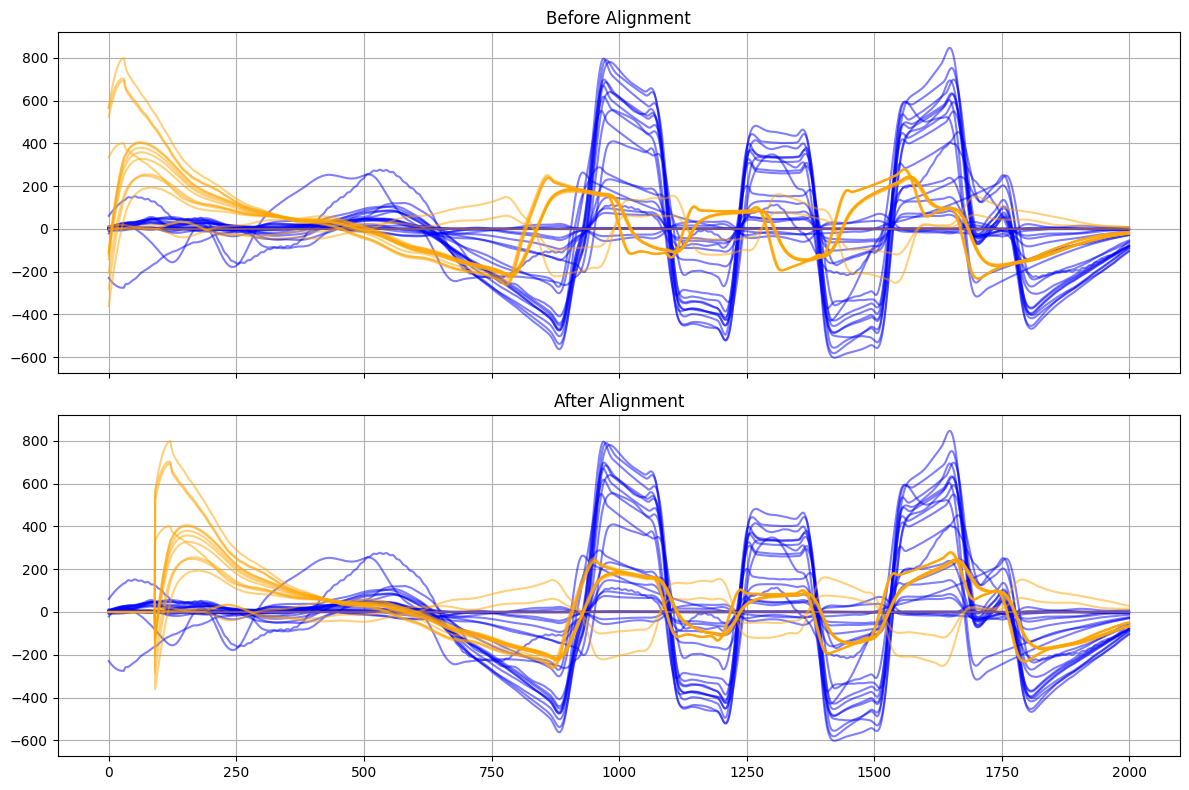

2025-06-21 13:13:22,299 - INFO - Resampling data from 1000Hz to 250Hz. Target length: 73042, Original length: 292171 samples.


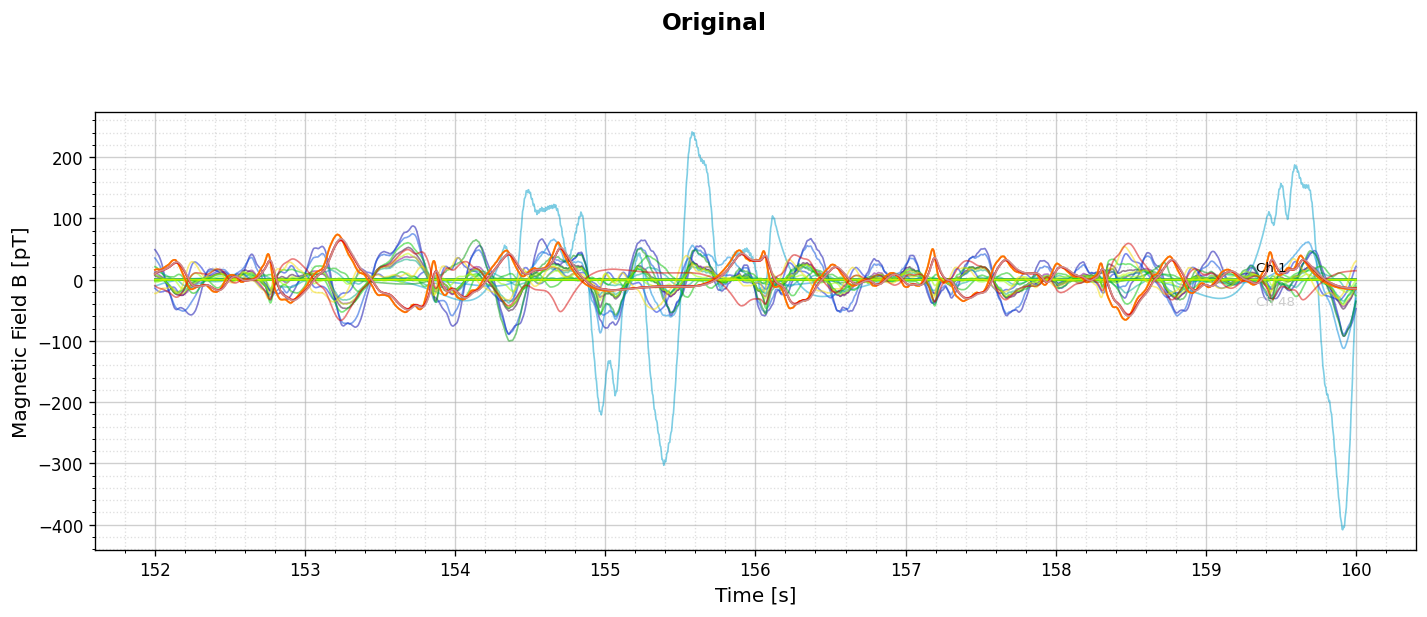

2025-06-21 13:13:24,582 - WARNING - No peaks detected.


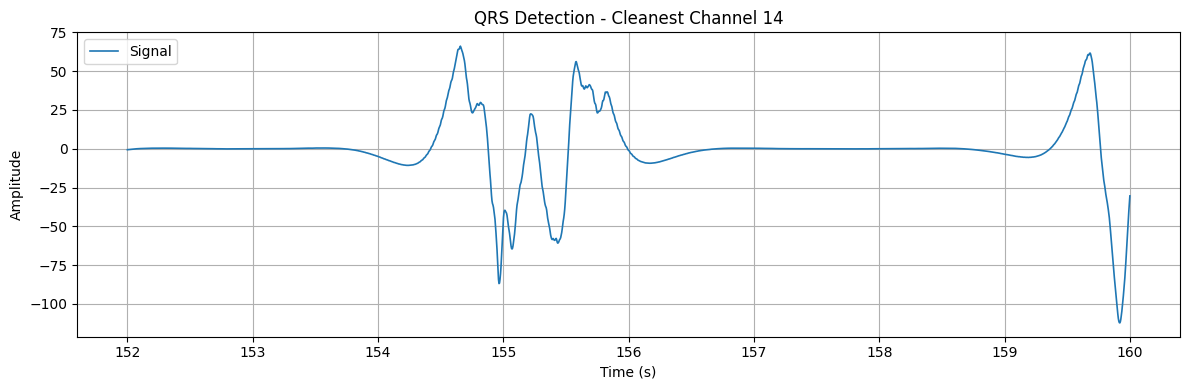

NameError: name 'avg_channels' is not defined

In [6]:
patient = "P019" #"P015/P015_S01_D2024-07-06"
date = "2024-08-29"
run = "S01"

log_file_path = f"Data/{patient}/QZFM_log_file.txt"
add_filename = f"Data/{patient}/{patient}_{run}_D{date}_addCh.tdms"
file_name = f"Data/{patient}/{patient}_{run}_D{date}.tdms"

analysis = Analyzer(
        filename=file_name,
        add_filename=add_filename,
        log_file_path=log_file_path,
        model_checkpoint_dir="MCG_segmentation/trained_models/MCGSegmentator_s",
        sensor_channels_to_exclude={}
    )

(x_data, y_data, z_data), time, single_run = analysis.prepare_data("Brustlage", apply_default_filter=True, plot_alignment=True)

single_run = single_run[:, 38000:40000]
time = time[38000:40000]

analysis.butterfly_plot(single_run, time, 48, f"Original")

peak_positions, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run, print_heart_rate=True, confidence_threshold=0.7)

plt.figure(figsize=(12, 4))
plt.plot(time, single_run[ch, :], label='Signal', linewidth=1.2)
plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


if peak_positions is not None and len(peak_positions) > 0:
    # window averaging
    avg_channels, time_window = analysis.avg_window(single_run, peak_positions, window_left=0.3, window_right=0.5)
    analysis.butterfly_plot(avg_channels, time_window, 48, f"Original")


# Example: Apply LSD plotting to QRS-aligned average data
channels_to_plot = list(range(avg_channels.shape[0]))  # or a subset if too many

# Create dummy noise_theos (or load actual theoretical noise floor if available)
noise_theos = [1.0] * len(channels_to_plot)  # Replace with real values if you have them


# Call your function
analysis.plot_lsd_multichannel(
    data=avg_channels,
    noise_theos=noise_theos,
    channels=channels_to_plot,
)

